# 목표

- BMI 지수 = (몸무게 / 키) * 키
- BMI를 이용하여 비만도를 측정
- 알고리즘 SVM을 이용하여 BMI를 학습, 비만도 판정

# 데이터 획득

In [0]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('3_bmi.csv')
df.head(2)

,height,weight,label
0,178,69,normal
1,190,62,thin


# 데이터 준비
- 품질 향상

In [3]:
df.shape, df.columns, df['label'].unique()

((20000, 3),
 Index(['height', 'weight', 'label'], dtype='object'),
 array(['normal', 'thin', 'fat'], dtype=object))

In [4]:
df.dtypes

height     int64
weight     int64
label     object
dtype: object

In [5]:
df['height'].max(), df['height'].min(), df['weight'].max(), df['weight'].min()

(200, 120, 80, 35)

In [6]:
# 데이터 정규화 -> 무게, 키의 최대치를 기준으로 처리
# 처리된 값을 다시 해당 컬럼에 대입

df['height'] = df['height'] / df['height'].max()
df['weight'] = df['weight'] / df['weight'].max()
df.head(2)

,height,weight,label
0,0.89,0.8625,normal
1,0.95,0.7750,thin


In [0]:
# label은 종속변수. 분류를 벡터화해서 처리
# 케이스 총 3개
# thin->[1, 0, 0] / normal->[0, 1, 0] / fat->[0, 0, 1]
df['label'] = df['label'].apply(lambda x : {'thin':np.array([1,0,0]), 'normal':np.array([0,1,0]), 'fat':np.array([0,0,1])}[x])

In [0]:
# 데이터 분류
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df[['height', 'weight']], df['label'], test_size=0.25, random_state=0)

# 데이터 분석
- 생략

# 머신러닝 모델링(딥러닝, 텐서플로우 사용)
 - 퍼셉트론
 - 각각의 출력값에 대해 가중치 계산, 바이어스(편향, 조정한 값)를 더해서 softmax라는 함수로 적용
 - 해당 이론을 수식으로 정리하여 함수로 표현
 - y = softmax(Wx + b)

## 데이터 플로우 그래프 준비

In [10]:
import tensorflow as tf
%tensorflow_version 1.x

In [0]:
# 텐서플로우로 수식 구현
# input(x): 키, 몸무게
x = tf.placeholder(tf.float32, [None,2])

In [0]:
# 가중치: shape 고려
W = tf.Variable(tf.zeros([2,3]))

In [0]:
# b(bias): 편향값
b = tf.Variable(tf.zeros([3]))

In [0]:
# 데이터 플로우 그래프: y = softmax(Wx+b)
# x: matrix, 2차 행렬, [none, 2]
# 행렬의 곱 (none, 2) * (2, 3) -> (none, 3)
# bias값은 브로드캐스팅에 의해 stretch 되어 연산
y = tf.nn.softmax(tf.matmul(x,W)+b)

In [15]:
f'{x.shape} X {W.shape} + {b.shape} = {y.shape}'

'(?, 2) X (2, 3) + (3,) = (?, 3)'

## 학습에 필요한 데이터 플로우 그래프 추가

- 좋은 모델을 만들기 위한 장치
  - 비용(cost), 손실(loss) 등의 값들이 원하는 결과에서 얼마나 떨어져 있는가를 판단/ 이 값들을 줄이는 방향으로 전개
  - 이런 처리를 위해서 '크로스 엔트로피'와 같은 알고리즘 적용
  - 정보 이론 분야의 정보 압축 알고리즘으로 고안되었음


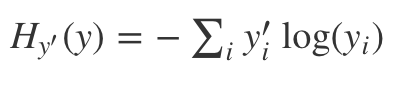

In [19]:
from IPython.display import Image
# 크로스 엔트로피 함수
Image('/content/sm4.png', width=300)

In [0]:
# y_: 정답 label
# y : 예측 label
# y_ = [1,0,0], [0,1,0], [0,0,1] => [None, 3]
y_ = tf.placeholder(tf.float32, [None,3])

In [0]:
# 크로스 엔트로피를 구성
cross_entropy = -tf.reduce_sum(y_ * tf.log(y))

In [0]:
# 크로스 엔트로피가 최소화 되도록 작업을 진행
# 경사 하강법(Gradient descent algorithm)으로 수행
# 텐서플로우가 변수의 비용을 줄이는 방향으로 조금씩 이동시켜서 연산 수행 => 비용과 손실, 오차율이 최소가 되게끔
# 하이퍼파라미터는 일단 0.01 적용
optimizer = tf.train.GradientDescentOptimizer(0.01)

In [0]:
# 훈련 정의
train = optimizer.minimize(cross_entropy)

In [0]:
# 정답률 예측 정의
# tf.argmax(y,1): 모델이 각 데이터별로 적합하다고 판단하는 레이블 값을 취함
predict = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))

In [0]:
# 정확도
accuracy = tf.reduce_mean(tf.cast(predict, tf.float32))

## 세션 가동 및 실행

- 데이터를 증가시키면서 반복 학습 방법
  1. 0\~100, 0\~200, ... 데이터의 전체 양 증가
  2. 0\~100, 100\~200, ... 데이터의 양 고정, 횟수만 증가
  - 횟수 증가

In [26]:
with tf.Session() as sess:
  # 1. 변수(조건) 초기화
  sess.run(tf.global_variables_initializer())
  
  # 2. 훈련 데이터를 나누기 위한 기준값 정의
  # 2-1. 훈련 한번 수행시 데이터 크기
  TRAIN_TERM = 100
  # 2-2. 훈련 진행 횟수
  train_count = int(X_train.shape[0] / TRAIN_TERM)
  
  # 3. 반복 학습 수행
  for step in range(train_count):
    # 3-1. 훈련데이터에서 데이터를 순차적으로 추출
    offset = step * TRAIN_TERM
    # datas = X_train[offset : offset + TRAIN_TERM]
    # 3-2. 학습
    # 학습 데이터 준비: 플레이스홀더에 값 채우기
    # 테스트 데이터와 학습 데이터의 피쳐 순서 맞춰야 함
    fd = {x:X_train[offset : offset + TRAIN_TERM], y_:list(y_train[offset : offset + TRAIN_TERM])}
    # 학습 수행
    sess.run(train, feed_dict=fd)
    # 중간 확인
    if step%10 == 0:
      # 크로스 엔트로피 값 획득
      cross_en = sess.run(cross_entropy, feed_dict=fd)
      # 정확도 획득: 테스트 데이터와 데스트 데이터의 답을 주입
      acc = sess.run(accuracy, feed_dict={x:X_test, y_:list(y_test)})
      
      print(f'step={step}, cross={cross_en}, acc={acc}')
  acc = sess.run(accuracy, feed_dict={x:X_test, y_:list(y_test)})
  print(f'마지막 횟수의 정확도={acc}') 


step=0, cross=106.28909301757812, acc=0.37880000472068787
step=10, cross=101.96707153320312, acc=0.5339999794960022
step=20, cross=100.24037170410156, acc=0.682200014591217
step=30, cross=94.66569519042969, acc=0.6797999739646912
step=40, cross=93.02731323242188, acc=0.6715999841690063
step=50, cross=91.35393524169922, acc=0.6862000226974487
step=60, cross=81.40003967285156, acc=0.6728000044822693
step=70, cross=84.91597747802734, acc=0.7228000164031982
step=80, cross=84.13021087646484, acc=0.6949999928474426
step=90, cross=81.22965240478516, acc=0.6832000017166138
step=100, cross=78.5992431640625, acc=0.7426000237464905
step=110, cross=78.42161560058594, acc=0.6772000193595886
step=120, cross=75.88557434082031, acc=0.70660001039505
step=130, cross=77.74769592285156, acc=0.6844000220298767
step=140, cross=68.8153076171875, acc=0.6913999915122986
마지막 횟수의 정확도=0.7455999851226807


In [41]:
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  TRAIN_TERM = 100
  train_count = int(X_train.shape[0] / TRAIN_TERM)
  # 훈련 횟수 증가
  STEP_SEGMENT = 2*2*2*2
  for step in range(train_count*STEP_SEGMENT):
    offset = int(step * TRAIN_TERM / STEP_SEGMENT)
    fd = {x:X_train[offset : offset + TRAIN_TERM], y_:list(y_train[offset : offset + TRAIN_TERM])}
    sess.run(train, feed_dict=fd)
    if step%STEP_SEGMENT == 0:
      cross_en = sess.run(cross_entropy, feed_dict=fd)
      acc = sess.run(accuracy, feed_dict={x:X_test, y_:list(y_test)})
      print(f'step={step}, cross={cross_en}, acc={acc}')
  acc = sess.run(accuracy, feed_dict={x:X_test, y_:list(y_test)})
  print(f'마지막 횟수의 정확도={acc}') 

step=0, cross=106.28909301757812, acc=0.37880000472068787
step=16, cross=97.68382263183594, acc=0.40459999442100525
step=32, cross=94.61579895019531, acc=0.6230000257492065
step=48, cross=91.69449615478516, acc=0.7016000151634216
step=64, cross=87.54940795898438, acc=0.718999981880188
step=80, cross=81.4825210571289, acc=0.8050000071525574
step=96, cross=81.07170104980469, acc=0.6610000133514404
step=112, cross=78.85374450683594, acc=0.753600001335144
step=128, cross=73.00946044921875, acc=0.7486000061035156
step=144, cross=75.01828002929688, acc=0.8180000185966492
step=160, cross=68.12228393554688, acc=0.6909999847412109
step=176, cross=62.46381759643555, acc=0.6827999949455261
step=192, cross=65.49154663085938, acc=0.6866000294685364
step=208, cross=67.22737884521484, acc=0.7401999831199646
step=224, cross=64.77497100830078, acc=0.7441999912261963
step=240, cross=65.12562561035156, acc=0.84579998254776
step=256, cross=68.32593536376953, acc=0.8619999885559082
step=272, cross=62.62219

# 텐서보드

- 목적: 텐서보드를 이용하여 그래프(데이터 흐름)를 시각적으로 확인
- 방법(코드적으로 조금 다름)
  1. 로컬 PC에서 수행
  2. colab에서 수행
  * 데이터가 누적되기 때문에 클리어 후 처리해야 정확하게 나옴

In [0]:
# 텐서보드를 위해서 추가된 코드(colab)
from tensorboardcolab import * 
import shutil, os
tf.reset_default_graph()

In [57]:
# 텐서 데이터 플로우 구현
x             = tf.placeholder( tf.float32, [None,2] )
y_            = tf.placeholder( tf.float32, [None, 3] )        # 정답

with tf.name_scope('interface') as scope:
  W             = tf.Variable( tf.zeros([2, 3]) ) 
  b             = tf.Variable( tf.zeros([3]) )
  with tf.name_scope('activation') as scope:
	  y  = tf.nn.softmax(tf.matmul(x,W) + b)      # 간단한 입력->출력층구성

with tf.name_scope('loss') as scope:
	cross_entropy = -tf.reduce_sum( y_ * tf.log(y) )               # 크로스엔트로피

with tf.name_scope('train') as scope:
	optimazer     = tf.train.GradientDescentOptimizer(0.01)        # 경사하강법
	train         = optimazer.minimize( cross_entropy )            # 훈련

with tf.name_scope('accuracy') as scope:
  predict       = tf.equal( tf.argmax(y, 1), tf.argmax(y_, 1) )  # 예측
  accuracy      = tf.reduce_mean( tf.cast(predict, tf.float32) ) # 평가

# 텐서보드를 위해서 추가된 코드(코렙에서 사용하는 스타일) --------------------
from tensorboardcolab import *
import shutil, os
# 디렉토리 및 그 이하 파일가지 삭제, 에러나면 무시
shutil.rmtree('./Graph', ignore_errors=True) 
# 디렉토리 생성
os.mkdir('./Graph')
# 기존의 tf에 만들어진 요소들 초기화 처리(에러가 날수도 있다)
# tf.reset_default_graph()
# 텐서보드 객체 생성
tbc = TensorBoardColab()
# ---------------------------------------------------------------------------

# 실행을 통한 학습,예측처리
with tf.Session() as sess:
  sess.run( tf.global_variables_initializer() )
  TRAIN_TERM = 100  
  train_count = int(X_train.shape[0] / TRAIN_TERM)  
  STEP_SEGMENT = 2*2*2*2
  for step in range(train_count*STEP_SEGMENT): # step:(0~149)    
    offset = int(step*TRAIN_TERM / STEP_SEGMENT)
    fd = {x:X_train[offset : offset + TRAIN_TERM], y_:list(y_train[offset : offset + TRAIN_TERM])}
    sess.run( train, feed_dict=fd )
    if step%STEP_SEGMENT == 0:
      cross_en = sess.run( cross_entropy, feed_dict=fd )
      acc      = sess.run( accuracy, feed_dict={x:X_test, y_:list(y_test)} )
      print(f'step={step}, cross={cross_en}, acc={acc}')
  acc = sess.run( accuracy, feed_dict={x:X_test, y_:list(y_test)} )
  print( f'정확도: {acc}')
  # 코렙 텐서보드의 물리적위치에 그래프를 기록한다 ----------------------
  writer = tbc.get_writer()
  writer.add_graph( sess.graph ) # 그래프 추가=
  writer.flush() # 강제로 전송
  # ---------------------------------------------------------------------

# 텐서보드를 닫는다 
tbc.close()

Wait for 8 seconds...
TensorBoard link:
https://ad331172.ngrok.io
step=0, cross=106.28909301757812, acc=0.37880000472068787
step=16, cross=97.68382263183594, acc=0.40459999442100525
step=32, cross=94.61579895019531, acc=0.6230000257492065
step=48, cross=91.69449615478516, acc=0.7016000151634216
step=64, cross=87.54940795898438, acc=0.718999981880188
step=80, cross=81.4825210571289, acc=0.8050000071525574
step=96, cross=81.07170104980469, acc=0.6610000133514404
step=112, cross=78.85374450683594, acc=0.753600001335144
step=128, cross=73.00946044921875, acc=0.7486000061035156
step=144, cross=75.01828002929688, acc=0.8180000185966492
step=160, cross=68.12228393554688, acc=0.6909999847412109
step=176, cross=62.46381759643555, acc=0.6827999949455261
step=192, cross=65.49154663085938, acc=0.6866000294685364
step=208, cross=67.22737884521484, acc=0.7401999831199646
step=224, cross=64.77497100830078, acc=0.7441999912261963
step=240, cross=65.12562561035156, acc=0.84579998254776
step=256, cross=

# 시스템 통합
- 산출물 skip